In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from cv_proj_imports import *
from cv_proj_consts import *
from cv_proj_utils import *
from cv_proj_explore_map5_metric import *
from cv_proj_trainval_split import *

/home/crazy_slime/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
# transformations
# we get the filenames as input, and output:
# x as the image
# y as the whale name
tfms_x = [PILImage.create]
tfms_y = [filename_label, lambda o: train_labels_dict[o], Categorize()]
tfms = [tfms_x, tfms_y]

ds_img_tfms = [ToTensor(), Resize(224)]

dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(*imagenet_stats)]
dl_tfms.extend(aug_transforms(
    do_flip=False, # flipping makes it a different whale identity!
    flip_vert=False,
    max_rotate=30.,
    max_zoom=1.,
    max_lighting=0.4,
    max_warp=0.1,
    p_affine=0.75,
    p_lighting=0.75,
    pad_mode=PadMode.Border
))

In [4]:
trainval_splits = get_trainval_splits()
train_ds = DataSource(train_image_files, tfms, splits=trainval_splits)
train_db = train_ds.databunch(after_item=ds_img_tfms, after_batch=dl_tfms, bs=32, num_workers=0)

We will use 1078 whales for initial train/val


In [5]:
opt_func = partial(Adam, lr=5e-3, wd=0.01)

In [6]:
from fastai2.vision.learner import _resnet_split

learn = cnn_learner(train_db, models.resnet34, loss_func=CrossEntropyLossFlat(), cut=-2, splitter = _resnet_split, opt_func=opt_func, metrics=[error_rate, mapk])

'Chosen LR: 0.03981071705534969'

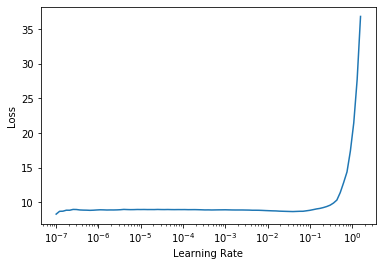

In [7]:
chosen_lr = find_best_lr(learn); f"Chosen LR: {chosen_lr}"

In [8]:
class FixedReduceLROnPlateau(TrackerCallback):
    "A `TrackerCallback` that reduces learning rate when a metric has stopped improving."
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=1, factor=10.):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta)
        self.patience,self.factor = patience,factor

    def begin_fit(self): self.wait = 0; super().begin_fit()
    def after_epoch(self):
        "Compare the value monitored to its best score and maybe stop training."
        super().after_epoch()
        if self.new_best: self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                for h in self.opt.hypers:
                    old_lr = h['lr']
                    new_lr = old_lr / self.factor
                    h['lr'] = new_lr
                    print(f'Epoch {self.epoch}: reducing lr from {old_lr} to {new_lr} in {h} with hypers {str(self.opt.hypers)}')
                self.wait = 0                

In [9]:
learn_cbs = [
    EarlyStoppingCallback(monitor='mapk', patience=20),
    SaveModelCallback(monitor='mapk', fname='embedding_resnet34_20191027_v2_best'),
    FixedReduceLROnPlateau(monitor='mapk', patience=5)
]

learn.fit(500, lr=chosen_lr/10., cbs=learn_cbs)

Epoch 45: reducing lr from 0.003981071705534969 to 0.0003981071705534969 in {'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.0003981071705534969, 'mom': 0.9, 'eps': 1e-05} with hypers (#3) [{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.0003981071705534969, 'mom': 0.9, 'eps': 1e-05},{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.003981071705534969, 'mom': 0.9, 'eps': 1e-05},{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.003981071705534969, 'mom': 0.9, 'eps': 1e-05}]
Epoch 45: reducing lr from 0.003981071705534969 to 0.0003981071705534969 in {'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.0003981071705534969, 'mom': 0.9, 'eps': 1e-05} with hypers (#3) [{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.0003981071705534969, 'mom': 0.9, 'eps': 1e-05},{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.0003981071705534969, 'mom': 0.9, 'eps': 1e-05},{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.003981071705534969, 'mom': 0.9, 'eps': 1e-05}]
Epoch 45: reducing lr from 0.003981071705534969 to 0.0003981071705534969 in {'sqr_mom': 0.99, 'wd': 0.01, 'lr': 0.0003981071705534969

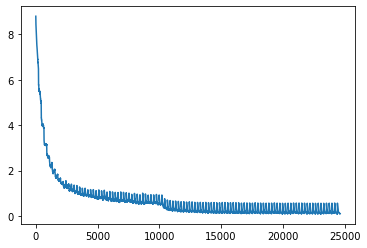

In [10]:
learn.recorder.plot_loss()

In [11]:
learn.unfreeze()

'Chosen LR: 0.0001584893192461114'

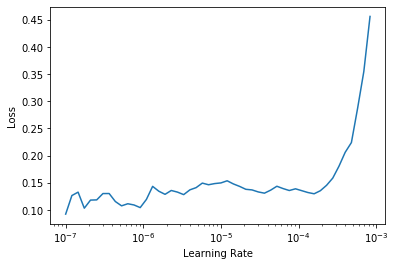

In [12]:
chosen_lr = find_best_lr(learn); f"Chosen LR: {chosen_lr}"

In [13]:
learn_cbs = [
    EarlyStoppingCallback(monitor='mapk', patience=20),
    SaveModelCallback(monitor='mapk', fname='embedding_resnet34_20191027_v2_unfreeze_best'),
    FixedReduceLROnPlateau(monitor='mapk', patience=5)
]

learn.fit(500, lr=chosen_lr/10., cbs=learn_cbs)

Epoch 12: reducing lr from 1.5848931924611138e-05 to 1.5848931924611139e-06 in {'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1.5848931924611139e-06, 'mom': 0.9, 'eps': 1e-05} with hypers (#3) [{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1.5848931924611139e-06, 'mom': 0.9, 'eps': 1e-05},{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1.5848931924611138e-05, 'mom': 0.9, 'eps': 1e-05},{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1.5848931924611138e-05, 'mom': 0.9, 'eps': 1e-05}]
Epoch 12: reducing lr from 1.5848931924611138e-05 to 1.5848931924611139e-06 in {'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1.5848931924611139e-06, 'mom': 0.9, 'eps': 1e-05} with hypers (#3) [{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1.5848931924611139e-06, 'mom': 0.9, 'eps': 1e-05},{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1.5848931924611139e-06, 'mom': 0.9, 'eps': 1e-05},{'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1.5848931924611138e-05, 'mom': 0.9, 'eps': 1e-05}]
Epoch 12: reducing lr from 1.5848931924611138e-05 to 1.5848931924611139e-06 in {'sqr_mom': 0.99, 'wd': 0.01, 'lr': 1

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  